# Task Scheduling for optimal power management in CubeSats

In [9]:
# # Install dependencies if not done, already
# !pip install skyfield pulp matplotlib pandas numpy

In [2]:
from skyfield.api import EarthSatellite,load
from datetime import timedelta,datetime
from skyfield.api import wgs84
import numpy as np
import pulp
import matplotlib.pyplot as plt
import time
import pandas as pd
from pulp import PULP_CBC_CMD

# DATA INPUT 

Power Input Modelling

In [3]:
def sunlit_power(satellite: EarthSatellite,
                 start:datetime,
                 t:int):
    ts = load.timescale()
    # satellite = EarthSatellite(tle_line_1, tle_line_2, Sat_name, ts)
    eph = load('de421.bsp')
    time_step = start + timedelta(minutes= t)
    time_step_skyfield = ts.utc(time_step.year, time_step.month, time_step.day, time_step.hour, time_step.minute, time_step.second)
    sunlit = satellite.at(time_step_skyfield).is_sunlit(eph)
    if satellite.name == '1U':
        Avg_power = 5
    elif satellite.name == '2U':
        Avg_power = 8
    else:
        Avg_power = 10 
        
    if sunlit:
        available_power = 0.8 * Avg_power
    else:
        available_power = 0
        
    return available_power 

Reading TLE Data

In [4]:
# Read the TLE file
with open("TLE.txt", "r") as file:
    lines = file.readlines()

ts = load.timescale()
# Process the TLE data
satellites = []
i = 0
while i < len(lines):
    if lines[i].strip():  # Check if line is not empty
        name = lines[i].strip()
        line1 = lines[i + 1].strip()
        line2 = lines[i + 2].strip()
        satellite = EarthSatellite(line1, line2, name, ts)
        satellites.append(satellite)
        i += 3  # Move to the next satellite data
    else:
        i += 1  

Dictionary for Satellite Input Parameters

In [5]:
# Satellite data for 1U Cubesat
satellite_data_1U = {
    'priority': [2, 1, 1],  # Priority for tasks (u_j)
    'power_consumption': [1.0, 1.3, 0.9],  # Power consumption (q_j)
    'ymin': [1, 3, 2],
    'ymax': [4, 3, 5],
    'tmin': [10, 3, 4],
    'tmax': [100, 100, 100],
    # 'tmin': [1, 2, 1],
    # 'tmax': [3, 3, 3],
    'pmin': [2, 2, 3],
    'pmax': [100, 100, 100],
    'wmin': [0, 0, 0],
    'wmax': [100, 100, 100],
    'rho': 0.5,
    'gamma': 2,
    'Vb':3.6,
    'e60': 0.9,
    'Q':10,
    'SoC':0.85 
    # 'available_power': 100  # Available power (r_t)
}
# Satellite data for 2U Cubesat
satellite_data_2U = {    
    'priority': [5, 2, 1, 4, 1, 3, 1, 1],  # Priority for tasks (column 3, u_j)
    'power_consumption': [1.0, 1.23, 0.8, 1.3, 1.5, 1.1, 1.1, 0.9],  # Power consumption (q_j) in Watts
    'ymin': [1, 1, 2, 1, 1, 1, 2, 2],
    'ymax': [3, 11, 5, 7, 10, 8, 7, 9],
    'tmin': [15, 7, 3, 6, 4, 4, 6, 3],
    'tmax': [40, 60, 80, 65, 70, 100, 100, 100],
    'pmin': [2, 4, 2, 6, 2, 4, 2, 2],
    'pmax': [100, 80, 100, 90, 90, 87, 60, 100],
    'wmin': [0, 0, 0, 0, 0, 40, 0, 0],
    'wmax': [100, 100, 100, 40, 100, 80, 100, 100],
    'rho': 0.5,
    'gamma': 2,
    'Vb':3.6,
    'e60': 0.9,
    'Q':10,
    'SoC':0.85
}

# Satellite data for 3U Cubesat
satellite_data_3U = {    
    'priority': [5, 2, 1, 4, 1, 3, 1, 1],  # priority (u_j)
    'power_consumption': [3.2, 1.23, 0.8, 1.3, 1.5, 1.1, 1.1, 0.9],  # Power consumption (q_j) in Watts
    'ymin': [2, 1, 2, 1, 1, 1, 2, 3],
    'ymax': [3, 4, 3, 7, 10, 8, 3, 9],
    'tmin': [10, 2, 3, 6, 1, 2, 4, 3],
    'tmax': [12, 50, 80, 65, 70, 100, 100, 100],
    'pmin': [5, 4, 2, 6, 2, 4, 2, 2],
    'pmax': [78, 50, 100, 90, 60, 87, 60, 40],
    'wmin': [0, 0, 0, 0, 0, 40, 0, 0],
    'wmax': [40, 100, 100, 40, 100, 80, 100, 100],
    'rho': 0.5,
    'gamma': 2,
    'Vb':3.6,
    'e60': 0.9,
    'Q':10,
    'SoC':0.85
}

# Preprocessing Steps before implementing Decomposition

Generating the requiried sets and profiles

In [11]:
def generate_feasible_profiles(satellite_data, num_time_slots):
    """
    Generate feasible execution profiles for a given task based on its constraints.
    """
    # feasible_profiles = []
    # power_usage = []
    # total_priority = []
    num_tasks = len(satellite_data['priority'])
    print(f"Number of tasks: {num_tasks}")
    master_inputs = {}
    # print(f"Number of tasks: {num_tasks}")
    # master_inputs = {}

    for i in range(num_tasks):

        feasible_profiles = []
        power_usage = []
        total_priority = []
        # num_tasks = len(satellite_data['priority'])     
        
        # Get task-specific constraints
        task_id = i  # Assuming task_id is the index of the task in the list
        tmin = satellite_data['tmin'][task_id]
        tmax = satellite_data['tmax'][task_id]
        priority = satellite_data['priority'][task_id]
        
        # forbidden_windows = satellite_data['forbidden_windows'][task_id]
        index = 0
        
        # Iterate over possible start times for the task
        for start_time in range(num_time_slots - tmin + 1):
            
            # total_priority = 0
            for duration in range(tmin, tmax + 1):
                
                # Generate a candidate profile for this start time and duration
                profile = [0] * num_time_slots
                power_consumed = [0] * num_time_slots
                
                
                for t in range(start_time, start_time + duration):
                    if t < num_time_slots:  # Ensure index is within bounds
                        profile[t] = 1
                        power_consumed[t] = satellite_data['power_consumption'][task_id] * profile[t]
                
                # Check if the profile violates any forbidden windows
                # if any(profile[t] == 1 and t in forbidden_windows for t in range(num_time_slots)):
                #     continue  # Skip this profile if it violates forbidden windows
                
                # Store the valid profile
                feasible_profiles.append(profile) 
                power_usage.append(power_consumed)
                total_priority.append(priority * sum(profile))            
                

            # print(profile)
            # print(f"priority : {priority}")
            
            # print(f"Total priority : {total_priority}")
            
            # master_inputs[f"theta_{task_id}"] = feasible_profiles
            master_inputs[f"q_{task_id}"] = power_usage
            master_inputs[f"c_{task_id}"] = total_priority
            index += 1

        print(f"Number of profiles_{i}: {len(feasible_profiles)}")

    return master_inputs   
    
    # return feasible_profiles

feasible_data_1U = generate_feasible_profiles(satellite_data_1U,100)
feasible_data_2U = generate_feasible_profiles(satellite_data_2U,100)

Number of tasks: 3
Number of profiles_0: 8281
Number of profiles_1: 9604
Number of profiles_2: 9409
Number of tasks: 8
Number of profiles_0: 2236
Number of profiles_1: 5076
Number of profiles_2: 7644
Number of profiles_3: 5700
Number of profiles_4: 6499
Number of profiles_5: 9409
Number of profiles_6: 9025
Number of profiles_7: 9604


In [6]:
def generate_feasible_profiles(satellite_data, num_time_slots):
    """
    Generate feasible execution profiles for a given task based on its constraints.
    Returns a dictionary where each task's profiles are stored as a list of dictionaries
    with 'priority' and 'power_usage' fields.
    """
    num_tasks = len(satellite_data['priority'])
    print(f"Number of tasks: {num_tasks}")
    
    current_profiles = {}  # Changed to store profiles in the required format

    for task_id in range(num_tasks):
        feasible_profiles = []  # List to store profile dictionaries for this task

        # Get task-specific constraints
        tmin = satellite_data['tmin'][task_id]
        tmax = satellite_data['tmax'][task_id]
        priority = satellite_data['priority'][task_id]
        power_consumption = satellite_data['power_consumption'][task_id]

        # Iterate over possible start times for the task
        for start_time in range(num_time_slots - tmin + 1):
            for duration in range(tmin, tmax + 1):
                # Generate a candidate profile for this start time and duration
                profile = [0] * num_time_slots
                power_usage = [0] * num_time_slots

                # Set the profile and power usage for the duration
                for t in range(start_time, start_time + duration):
                    if t < num_time_slots:  # Ensure index is within bounds
                        profile[t] = 1
                        power_usage[t] = power_consumption * profile[t]

                # Calculate the total priority (priority * number of active slots)
                profile_priority = priority * sum(profile)

                # Store the profile as a dictionary
                feasible_profiles.append({
                    'priority': profile_priority,
                    'power_usage': power_usage
                })

        print(f"Number of profiles_{task_id}: {len(feasible_profiles)}")
        current_profiles[task_id] = feasible_profiles

    return current_profiles

# Example usage
feasible_data_1U = generate_feasible_profiles(satellite_data_1U, 100)
feasible_data_2U = generate_feasible_profiles(satellite_data_2U, 100)

# The output (feasible_data_1U and feasible_data_2U) is now directly in the format expected by solve_rmp,
# so you can use it like this:
# selected_profiles = solve_rmp(satellite_data_1U, satellite_info, feasible_data_1U, 100, mu_j, pi_t, nu_t, start_time)

Number of tasks: 3
Number of profiles_0: 8281
Number of profiles_1: 9604
Number of profiles_2: 9409
Number of tasks: 8
Number of profiles_0: 2236
Number of profiles_1: 5076
Number of profiles_2: 7644
Number of profiles_3: 5700
Number of profiles_4: 6499
Number of profiles_5: 9409
Number of profiles_6: 9025
Number of profiles_7: 9604


In [8]:
feasible_data_2U[0]

[{'priority': 75,
  'power_usage': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]},
 {'priority': 80,
  'power_usage': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,


# Column Generation Loop

Subproblem Formulation

In [ ]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus

def solve_rmp(satellite_data,satellite_info,current_profiles, num_time_slots, mu_j, pi_t, nu_t,start_time):
    """
    Solve the Restricted Master Problem (RMP) with the current profiles.
    """
    rmp_problem = LpProblem("RMP", LpMaximize)

    # Battery & Power Variables
    b = pulp.LpVariable.dicts('b', range(num_time_slots), lowBound=0)  # Remaining battery power
    i = pulp.LpVariable.dicts('i', range(num_time_slots), lowBound=0)  # Current flow
    SoC = pulp.LpVariable.dicts('SoC', range(num_time_slots + 1), lowBound=satellite_data['rho'], upBound=1)  # State of Charge
    alpha = pulp.LpVariable.dicts('alpha', range(num_time_slots), lowBound=0, upBound=1)

    # Define decision variables ξk_j for each profile
    xi_kj = LpVariable.dicts(f"xi", [(task_id, idx) for task_id in range(len(satellite_data['priority'])) for idx in range(len(current_profiles[task_id]))], 0, 1, cat="Binary")

    # Objective: Maximize total priority
    rmp_problem += lpSum(current_profiles[task_id][idx]['priority'] * xi_kj[task_id, idx] for task_id in range(len(satellite_data['priority'])) for idx in range(len(current_profiles[task_id])))

    # Constraints: Ensure that for each task, only one profile is selected
    for task_id in range(len(satellite_data['priority'])):
        rmp_problem += lpSum(xi_kj[task_id, idx] for idx in range(len(current_profiles[task_id]))) == 1

    # Constraints for power consumption (max capacity per time slot)
    # Constraints for power consumption (max capacity per time slot)
    for t in range(num_time_slots):
        rmp_problem += lpSum(
            current_profiles[task_id][idx]['power_usage'][t] * xi_kj[task_id, idx]
            for task_id in range(len(satellite_data['priority']))
            for idx in range(len(current_profiles[task_id]))
        ) + satellite_data['gamma'] * satellite_data['Vb'] * alpha[t] <= (
            sunlit_power(satellite_info, start_time, t) + satellite_data['gamma'] * satellite_data['Vb']
        )

    # Constraints for battery balance (b_t = r_t, i.e., battery level equals available power)
    for t in range(num_time_slots):
        rmp_problem += lpSum(
            current_profiles[task_id][idx]['power_usage'][t] * xi_kj[task_id, idx]
            for task_id in range(len(satellite_data['priority']))
            for idx in range(len(current_profiles[task_id]))
        ) + b[t] == sunlit_power(satellite_info, start_time, t) + satellite_data['gamma'] * satellite_data['Vb']

    # Constraints 2d - 2i

    # Current flow constraints (2d)
    for t in range(num_time_slots):
        rmp_problem += i[t] * satellite_data['Vb'] == b[t], f"Current_Flow_{t}"

    # State of Charge (SoC) constraints (2e)
    for t in range(num_time_slots):
        rmp_problem += SoC[t + 1] == SoC[t] + (i[t] * satellite_data['e60']) / satellite_data['Q'], f"SoC_Update_{t}"

    # SoC upper and lower limits (2f)(2g)
    for t in range(num_time_slots):
        rmp_problem += SoC[t] >= satellite_data['rho'], f"SoC_Lower_Limit_{t}"
        rmp_problem += SoC[t] <= 1, f"SoC_Upper_Limit_{t}"

    # Constraints 2y,2z             

    # Solve the RMP
    rmp_problem.solve()

    # Extract solution
    selected_profiles = []
    for task_id in range(len(satellite_data['priority'])):
        for idx in range(len(current_profiles[task_id])):
            if xi_kj[task_id, idx].varValue > 0.5:  # Profile is selected
                selected_profiles.append(current_profiles[task_id][idx])

    return selected_profiles


In [ ]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus, value

def solve_rmp(satellite_data, satellite_info, current_profiles, num_time_slots, mu_j, pi_t, nu_t, start_time):
    """
    Solve the Restricted Master Problem (RMP) with the current profiles and return selected profiles and dual values.
    """
    rmp_problem = LpProblem("RMP", LpMaximize)

    # Battery & Power Variables
    b = pulp.LpVariable.dicts('b', range(num_time_slots), lowBound=0)  # Remaining battery power
    i = pulp.LpVariable.dicts('i', range(num_time_slots), lowBound=0)  # Current flow
    SoC = pulp.LpVariable.dicts('SoC', range(num_time_slots + 1), lowBound=satellite_data['rho'], upBound=1)  # State of Charge
    alpha = pulp.LpVariable.dicts('alpha', range(num_time_slots), lowBound=0, upBound=1)

    # Define decision variables ξk_j for each profile
    xi_kj = LpVariable.dicts("xi", [(task_id, idx) for task_id in range(len(satellite_data['priority'])) 
                                    for idx in range(len(current_profiles[task_id]))], 0, 1, cat="Binary")

    # Objective: Maximize total priority
    rmp_problem += lpSum(current_profiles[task_id][idx]['priority'] * xi_kj[task_id, idx] 
                         for task_id in range(len(satellite_data['priority'])) 
                         for idx in range(len(current_profiles[task_id]))), "Objective"

    # Constraints: Ensure that for each task, only one profile is selected (Constraint 5b)
    dual_mu = {}  # To store dual variables for assignment constraints
    for task_id in range(len(satellite_data['priority'])):
        constraint_name = f"Assign_One_Profile_{task_id}"
        rmp_problem += lpSum(xi_kj[task_id, idx] for idx in range(len(current_profiles[task_id]))) == 1, constraint_name
        dual_mu[task_id] = rmp_problem.constraints[constraint_name]  # Store for dual extraction

    # Constraints for power consumption (max capacity per time slot) (Constraint 5c)
    dual_pi = {}  # To store dual variables for power capacity constraints
    for t in range(num_time_slots):
        constraint_name = f"Power_Capacity_{t}"
        rmp_problem += (lpSum(current_profiles[task_id][idx]['power_usage'][t] * xi_kj[task_id, idx]
                              for task_id in range(len(satellite_data['priority']))
                              for idx in range(len(current_profiles[task_id]))) 
                        + satellite_data['gamma'] * satellite_data['Vb'] * alpha[t] 
                        <= sunlit_power(satellite_info, start_time, t) + satellite_data['gamma'] * satellite_data['Vb']), constraint_name
        dual_pi[t] = rmp_problem.constraints[constraint_name]

    # Constraints for battery balance (b_t = r_t) (Constraint 5d)
    dual_nu = {}  # To store dual variables for battery balance constraints
    for t in range(num_time_slots):
        constraint_name = f"Battery_Balance_{t}"
        rmp_problem += (lpSum(current_profiles[task_id][idx]['power_usage'][t] * xi_kj[task_id, idx]
                              for task_id in range(len(satellite_data['priority']))
                              for idx in range(len(current_profiles[task_id]))) 
                        + b[t] == sunlit_power(satellite_info, start_time, t) + satellite_data['gamma'] * satellite_data['Vb']), constraint_name
        dual_nu[t] = rmp_problem.constraints[constraint_name]

    # Current flow constraints (2d)
    for t in range(num_time_slots):
        rmp_problem += i[t] * satellite_data['Vb'] == b[t], f"Current_Flow_{t}"

    # State of Charge (SoC) constraints (2e)
    for t in range(num_time_slots):
        rmp_problem += SoC[t + 1] == SoC[t] + (i[t] * satellite_data['e60']) / satellite_data['Q'], f"SoC_Update_{t}"

    # SoC upper and lower limits (2f)(2g)
    for t in range(num_time_slots):
        rmp_problem += SoC[t] >= satellite_data['rho'], f"SoC_Lower_Limit_{t}"
        rmp_problem += SoC[t] <= 1, f"SoC_Upper_Limit_{t}"

    # Solve the RMP
    status = rmp_problem.solve()

    if status != LpStatus.Optimal:
        raise ValueError("RMP did not solve to optimality")

    # Extract solution and dual variables
    selected_profiles = []
    for task_id in range(len(satellite_data['priority'])):
        for idx in range(len(current_profiles[task_id])):
            if xi_kj[task_id, idx].varValue > 0.5:  # Profile is selected
                selected_profiles.append(current_profiles[task_id][idx])

    # Extract dual variables
    optimal_mu = {task_id: value(dual_mu[task_id].pi) for task_id in dual_mu}
    optimal_pi = {t: value(dual_pi[t].pi) for t in dual_pi}
    optimal_nu = {t: value(dual_nu[t].pi) for t in dual_nu}

    return selected_profiles, optimal_mu, optimal_pi, optimal_nu


In [ ]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus

def solve_pricing_problem(satellite_data,task_id, mu_j, pi_t, nu_t, num_time_slots):
    """
    Solve the pricing problem (7a) for a specific task j to find new profiles.
    """
    # Create a new optimization problem for task j
    pricing_problem = LpProblem(f"Pricing Problem for Task {task_id}", LpMaximize)

    # Define decision variables: x_jt (task active at time t)
    x_jt = LpVariable.dicts(f"x_{task_id}", range(num_time_slots), 0, 1, cat="Binary")
    
    # Objective: Maximize priority minus reduced cost
    pricing_problem += satellite_data['priority'][task_id] * lpSum(x_jt[t] for t in range(num_time_slots)) \
                        - mu_j - lpSum(pi_t[t] + nu_t[t] * satellite_data['power_consumption'][task_id] * x_jt[t] for t in range(num_time_slots))

    # Constraints for task j (task start and duration within limits)
    tmin = satellite_data['tmin'][task_id]
    tmax = satellite_data['tmax'][task_id]
    
    # Ensure the task starts and ends within the allowed time slots
    pricing_problem += lpSum(x_jt[t] for t in range(num_time_slots)) >= tmin
    pricing_problem += lpSum(x_jt[t] for t in range(num_time_slots)) <= tmax

    # Solve the pricing problem
    pricing_problem.solve()

    # Check the solution
    if LpStatus[pricing_problem.status] == "Optimal":
        profile = [x_jt[t].varValue for t in range(num_time_slots)]
        reduced_cost = satellite_data['priority'][task_id] * sum(profile) \
                       - mu_j - sum((pi_t[t] + nu_t[t]) * satellite_data['power_consumption'][task_id] * profile[t] for t in range(num_time_slots))
        return profile, reduced_cost
    else:
        return None, 0


def column_generation(master_inputs,satellite_data, num_time_slots, max_iterations=100):
    """
    Perform the column generation process to solve the MILP using column generation.
    """
    current_profiles = [[] for _ in range(len(satellite_data['priority']))]  # Start with empty profiles

    # Initial profiles (could be empty or some basic feasible profiles)
    # master_inputs = generate_feasible_profiles(satellite_data, num_time_slots)

    # Set initial profiles for column generation
    for task_id in range(len(satellite_data['priority'])):
        for profile in master_inputs[f"theta_{task_id}"]:
            current_profiles[task_id].append({'profile': profile, 'priority': master_inputs[f"c_{task_id}"][profile], 'power_usage': master_inputs[f"q_{task_id}"][profile]})

    iteration = 0
    while iteration < max_iterations:
        # Solve the RMP with the current profiles
        selected_profiles = solve_rmp(satellite_data, current_profiles, num_time_slots, mu_j=0, pi_t=[0]*num_time_slots, nu_t=[0]*num_time_slots)

        # Solve the pricing problem for each task to generate new profiles
        new_profiles_added = False
        for task_id in range(len(satellite_data['priority'])):
            # Retrieve the dual values from RMP (for now, use dummy values, these would be extracted from RMP's dual variables)
            mu_j = 0  # Should be extracted from RMP's dual variables for task j
            pi_t = [0] * num_time_slots  # Dual variables for time slots
            nu_t = [0] * num_time_slots  # Dual variables for energy constraints

            profile, reduced_cost = solve_pricing_problem(satellite_data, task_id, mu_j, pi_t, nu_t, num_time_slots)
            if reduced_cost > 0:
                current_profiles[task_id].append({'profile': profile, 'priority': satellite_data['priority'][task_id] * sum(profile), 'power_usage': profile})
                new_profiles_added = True
                print(f"Added new profile for task {task_id} with reduced cost {reduced_cost}")

        # If no new profiles were added, we can stop the column generation process
        if not new_profiles_added:
            print("No new profiles with positive reduced cost found. Stopping iteration.")
            break

        iteration += 1

    return current_profiles

# Example usage:

# Run the column generation process
column_generation(satellite_data_1U, num_time_slots=100)


# Optimization Code for IP Model

Optimization Implementation using PuLP model in python

In [12]:
def Satellite_optimization(satellite_data,satellite_info,start_time):
    # Define number of tasks and time slots
    start = time.time()  # Start timing
    num_tasks = len(satellite_data['priority'])
    num_time_slots = 100  # Example time slots for scheduling

    # Create a Linear Program model
    model = pulp.LpProblem("Satellite_Scheduling", pulp.LpMaximize)

    # Decision Variables
    x = pulp.LpVariable.dicts('x', (range(num_tasks), range(num_time_slots)), cat='Binary')
    phi = pulp.LpVariable.dicts('phi', (range(num_tasks), range(num_time_slots)), cat='Binary')

    # Battery & Power Variables
    b = pulp.LpVariable.dicts('b', range(num_time_slots), lowBound=0)  # Remaining battery power
    i = pulp.LpVariable.dicts('i', range(num_time_slots), lowBound=0)  # Current flow
    SoC = pulp.LpVariable.dicts('SoC', range(num_time_slots + 1), lowBound=satellite_data['rho'], upBound=1)  # State of Charge
    # Decision Variable: Alpha_t (fuzzy battery access control)
    alpha = pulp.LpVariable.dicts('alpha', range(num_time_slots), lowBound=0, upBound=1)

    # Objective Function: Maximize the priority sum for scheduled tasks (2a)
    model += pulp.lpSum(satellite_data['priority'][j] * x[j][t] for j in range(num_tasks) for t in range(num_time_slots))

    # # Power consumption constraints
    # for t in range(num_time_slots):
    #     model += pulp.lpSum(satellite_data['power_consumption'][j] * x[j][t] for j in range(num_tasks)) <= sunlit_power(satellite_info, start_time, t), f"Power_Constraint_{t}"

    # # Updated Power Constraints
    # for t in range(num_time_slots):
    #     model += pulp.lpSum(satellite_data['power_consumption'][j] * x[j][t] for j in range(num_tasks)) <= (
    #         sunlit_power(satellite_info, start_time, t) + satellite_data['gamma'] * satellite_data['Vb'] * (1 - satellite_data['alpha'][t])
    #     ), f"Power_Constraint_{t}"

    # Updated Power Consumption Constraint (Fuzzy Constraint 2b)
    for t in range(num_time_slots):
     model += pulp.lpSum(satellite_data['power_consumption'][j] * x[j][t] for j in range(num_tasks)) <= (
        sunlit_power(satellite_info, start_time, t) + satellite_data['gamma'] * satellite_data['Vb'] * (1 - alpha[t])
    ), f"Fuzzy_Power_Constraint_{t}"
     
    # Battery discharge constraints (2c)
    for t in range(num_time_slots):
        model += b[t] == sunlit_power(satellite_info, start_time, t) - pulp.lpSum(satellite_data['power_consumption'][j] * x[j][t] for j in range(num_tasks)), f"Battery_Discharge_{t}"

    # Current flow constraints (2d)
    for t in range(num_time_slots):
        model += i[t] * satellite_data['Vb'] == b[t], f"Current_Flow_{t}"

    # for t in range(num_time_slots):
    #     model += i[t] == b[t] / satellite_data['Vb'], f"Current_Flow_{t}"

    # State of Charge (SoC) constraints (2e)
    for t in range(num_time_slots):
        model += SoC[t + 1] == SoC[t] + (i[t] * satellite_data['e60']) / satellite_data['Q'], f"SoC_Update_{t}"

    # SoC upper and lower limits (2f)(2g)
    for t in range(num_time_slots):
        model += SoC[t] >= satellite_data['rho'], f"SoC_Lower_Limit_{t}"
        model += SoC[t] <= 1, f"SoC_Upper_Limit_{t}"

    # # Final SoC condition (2h)(2i)
    # model += SoC[num_time_slots] <= SoC[0] * (1 + satellite_data['delta_SoC']), "Final_SoC_Upper"
    # model += SoC[num_time_slots] >= SoC[0] * (1 - satellite_data['delta_SoC']), "Final_SoC_Lower"    

    # Task start constraints (Start task at time 1)(2j)
    for j in range(num_tasks):
        model += phi[j][0] >= x[j][0], f"Task_Start_Constraint_{j}"

    # Task continuation constraints (Ensure tasks are either 0 or continuous)(2k)(2m)
    for j in range(num_tasks):
        for t in range(1, num_time_slots):
            model += phi[j][t] >= x[j][t] - x[j][t-1], f"Task_Continuation_Constraint_{j}_{t}"            
            model += phi[j][t] <= 2 - x[j][t] - x[j][t-1], f"Task_Continuation_Constraint_Upper_{j}_{t}"

    # Relationship between x and phi (2l): Ensure that if a task is scheduled, it must be continuous
    for j in range(num_tasks):
        for t in range(num_time_slots):
            model += phi[j][t] <= x[j][t], f"Realtionship_x_and_phi_{j}_{t}"

    # Total phi sum constraints: Ensure the total number of tasks scheduled for each payload is within [ymin, ymax](2n)(2o)
    for j in range(num_tasks):
        model += pulp.lpSum(phi[j][t] for t in range(num_time_slots)) >= satellite_data['ymin'][j], f"Min_Tasks_Constraint_{j}"
        model += pulp.lpSum(phi[j][t] for t in range(num_time_slots)) <= satellite_data['ymax'][j], f"Max_Tasks_Constraint_{j}"

    ##############################################################################################################################
    # (2p) Minimum execution time with activation
    for j in range(num_tasks):
        for t in range(num_time_slots - satellite_data['tmin'][j] + 1):  # Ensures valid range
            model += pulp.lpSum(x[j][l] for l in range(t, t + satellite_data['tmin'][j])) >= (
            satellite_data['tmin'][j] * phi[j][t]
            ), f"Min_Duration_Activation_{j}_{t}"

    # (2q) Maximum execution time constraint (rolling window)
    for j in range(num_tasks):
        for t in range(num_time_slots - satellite_data['tmax'][j]):  # Ensures valid range
         model += pulp.lpSum(x[j][l] for l in range(t, t + satellite_data['tmax'][j])) <= (
            satellite_data['tmax'][j]
            ), f"Max_Duration_Rolling_{j}_{t}"
         
    # (2r) Ensure tasks near the end of the time horizon meet minimum execution time
    for j in range(num_tasks):
        for t in range(num_time_slots - satellite_data['tmin'][j] + 2, num_time_slots):  # From T - t_min + 2 to T
            model += pulp.lpSum(x[j][l] for l in range(t, num_time_slots)) >= (
                (num_time_slots - t + 1) * phi[j][t]
            ), f"Min_Execution_End_{j}_{t}"

    # (2s) Ensure a minimum time gap between activations
    for j in range(num_tasks):
        for t in range(satellite_data['wmin'][j] + 1, satellite_data['wmax'][j] - satellite_data['pmin'][j]):  # Valid range
            model += pulp.lpSum(phi[j][l] for l in range(t, t + satellite_data['pmin'][j])) <= 1, f"Min_Activation_Gap_{j}_{t}"

    # (2t) Ensure a maximum time gap between activations
    for j in range(num_tasks):
        for t in range(satellite_data['wmin'][j] + 1, satellite_data['wmax'][j] - satellite_data['pmax'][j]):  # Valid range
            model += pulp.lpSum(phi[j][l] for l in range(t, t + satellite_data['pmax'][j])) >= 1, f"Max_Activation_Gap_{j}_{t}"



    # (2u)(2v) Forbidden windows constraints (wmin, wmax): Ensure tasks are not scheduled during forbidden time windows
    for j in range(num_tasks):
        for t in range(satellite_data['wmin'][j]):
            model += x[j][t] == 0, f"Forbidden_Start_Constraint_{j}_{t}"
        for t in range(satellite_data['wmax'][j], num_time_slots):
            model += x[j][t] == 0, f"Forbidden_End_Constraint_{j}_{t}"
    
    # Enforce 0 ≤ α_t ≤ 1 (Constraint 2y)
    for t in range(num_time_slots):
        model += alpha[t] >= 0, f"Alpha_Lower_Bound_{t}"
        model += alpha[t] <= 1, f"Alpha_Upper_Bound_{t}"



    # Solve the model
    # model.solve()
    model.solve(PULP_CBC_CMD())

    for constraint in model.constraints:
        print(constraint, model.constraints[constraint])
    # Computation Time
    end = time.time()  # End timing
    computation_time = end - start 

  # Code for plotting
    task_schedule = {}
    for j in range(num_tasks):
        scheduled_times = [t for t in range(num_time_slots) if pulp.value(x[j][t]) == 1]
        if scheduled_times:
            task_schedule[j] = scheduled_times

    # Convert to DataFrame for tabular output
    df_schedule = pd.DataFrame(list(task_schedule.items()), columns=['Task ID', 'Scheduled Time Slots'])

    # Format the Scheduled Time Slots column to display times in a readable way
    df_schedule['Scheduled Time Slots'] = df_schedule['Scheduled Time Slots'].apply(lambda x: ', '.join(map(str, x)))

    # Improve column formatting and table display
    df_schedule['Task ID'] = df_schedule['Task ID'].apply(lambda x: f"Task {x}")
    df_schedule = df_schedule[['Task ID', 'Scheduled Time Slots']]  # Reorganize columns for better readability

    # Display results
    print("\n===== Optimization Results =====")
    print(f"Status: {pulp.LpStatus[model.status]}")
    print(f"Objective Value: {pulp.value(model.objective)}")
    print(f"Computation Time: {computation_time:.4f} seconds")

    print("\n===== Scheduled Tasks =====")
    print(df_schedule.to_string(index=False, header=True))

    # Plotting task schedule as lines for each task
    plt.figure(figsize=(12, 6))

    # Define the vertical position (y) for each task
    task_heights = np.arange(num_tasks)

    # Plot each task as a line
    for task_id, times in task_schedule.items():
        # Create a line for each task: From 0 to 1 for the scheduled time slots
        y_values = np.zeros(num_time_slots)  # Initialize y values as "off" (0)
        y_values[times] = 1  # Set "on" (1) for scheduled times
        plt.plot(np.arange(num_time_slots), y_values + task_id*1.2, label=f"Task {task_id}", lw=2)  # Shift y-values for spacing

    # Adjust axis limits and labels
    plt.xlabel("Time Slots")
    plt.ylabel("Tasks")
    plt.title("Task Scheduling Over Time (Line Representation of Task Execution)")
    plt.yticks(task_heights + 0.5, [f"Task {i}" for i in range(num_tasks)])  # Position task labels

    plt.grid(True)
    plt.legend()
    plt.show()


# Computing results for 3 instances

Instance 1 - 1U Cubesat

Fuzzy_Power_Constraint_0 7.2*alpha_0 + x_0_0 + 1.3*x_1_0 + 0.9*x_2_0 <= 7.2
Fuzzy_Power_Constraint_1 7.2*alpha_1 + x_0_1 + 1.3*x_1_1 + 0.9*x_2_1 <= 7.2
Fuzzy_Power_Constraint_2 7.2*alpha_2 + x_0_2 + 1.3*x_1_2 + 0.9*x_2_2 <= 7.2
Fuzzy_Power_Constraint_3 7.2*alpha_3 + x_0_3 + 1.3*x_1_3 + 0.9*x_2_3 <= 7.2
Fuzzy_Power_Constraint_4 7.2*alpha_4 + x_0_4 + 1.3*x_1_4 + 0.9*x_2_4 <= 7.2
Fuzzy_Power_Constraint_5 7.2*alpha_5 + x_0_5 + 1.3*x_1_5 + 0.9*x_2_5 <= 11.2
Fuzzy_Power_Constraint_6 7.2*alpha_6 + x_0_6 + 1.3*x_1_6 + 0.9*x_2_6 <= 11.2
Fuzzy_Power_Constraint_7 7.2*alpha_7 + x_0_7 + 1.3*x_1_7 + 0.9*x_2_7 <= 11.2
Fuzzy_Power_Constraint_8 7.2*alpha_8 + x_0_8 + 1.3*x_1_8 + 0.9*x_2_8 <= 11.2
Fuzzy_Power_Constraint_9 7.2*alpha_9 + x_0_9 + 1.3*x_1_9 + 0.9*x_2_9 <= 11.2
Fuzzy_Power_Constraint_10 7.2*alpha_10 + x_0_10 + 1.3*x_1_10 + 0.9*x_2_10 <= 11.2
Fuzzy_Power_Constraint_11 7.2*alpha_11 + x_0_11 + 1.3*x_1_11 + 0.9*x_2_11 <= 11.2
Fuzzy_Power_Constraint_12 7.2*alpha_12 + x_0_12 + 1.3*x_1_12 + 0.9*x_2_

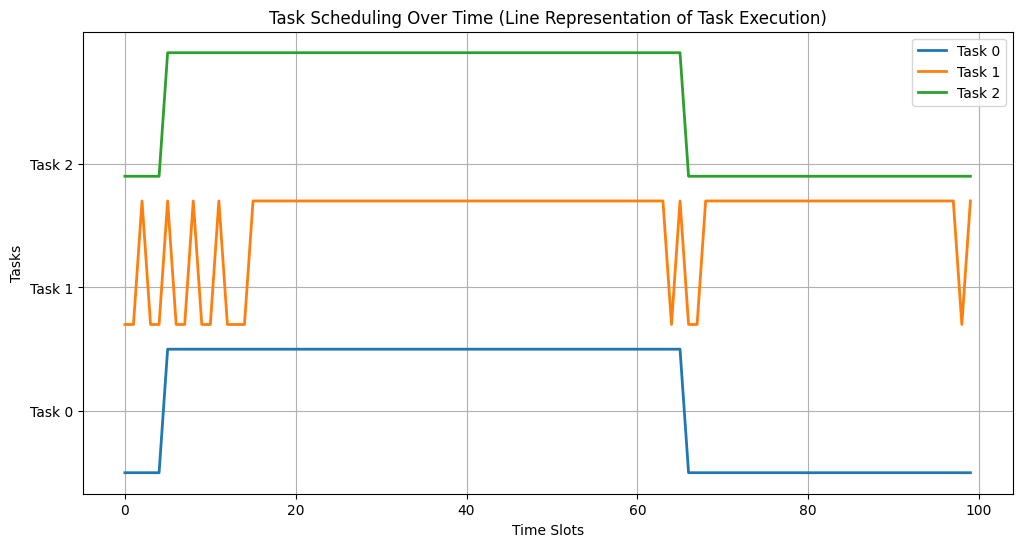

In [13]:
start_time = datetime(2025, 1, 1, 0, 0, 0)
Satellite_optimization(satellite_data_1U,satellites[0],start_time)

Instance 2 - 2U Cubesat

Fuzzy_Power_Constraint_0 7.2*alpha_0 + x_0_0 + 1.23*x_1_0 + 0.8*x_2_0 + 1.3*x_3_0 + 1.5*x_4_0 + 1.1*x_5_0 + 1.1*x_6_0 + 0.9*x_7_0 <= 13.600000000000001
Fuzzy_Power_Constraint_1 7.2*alpha_1 + x_0_1 + 1.23*x_1_1 + 0.8*x_2_1 + 1.3*x_3_1 + 1.5*x_4_1 + 1.1*x_5_1 + 1.1*x_6_1 + 0.9*x_7_1 <= 13.600000000000001
Fuzzy_Power_Constraint_2 7.2*alpha_2 + x_0_2 + 1.23*x_1_2 + 0.8*x_2_2 + 1.3*x_3_2 + 1.5*x_4_2 + 1.1*x_5_2 + 1.1*x_6_2 + 0.9*x_7_2 <= 13.600000000000001
Fuzzy_Power_Constraint_3 7.2*alpha_3 + x_0_3 + 1.23*x_1_3 + 0.8*x_2_3 + 1.3*x_3_3 + 1.5*x_4_3 + 1.1*x_5_3 + 1.1*x_6_3 + 0.9*x_7_3 <= 13.600000000000001
Fuzzy_Power_Constraint_4 7.2*alpha_4 + x_0_4 + 1.23*x_1_4 + 0.8*x_2_4 + 1.3*x_3_4 + 1.5*x_4_4 + 1.1*x_5_4 + 1.1*x_6_4 + 0.9*x_7_4 <= 13.600000000000001
Fuzzy_Power_Constraint_5 7.2*alpha_5 + x_0_5 + 1.23*x_1_5 + 0.8*x_2_5 + 1.3*x_3_5 + 1.5*x_4_5 + 1.1*x_5_5 + 1.1*x_6_5 + 0.9*x_7_5 <= 13.600000000000001
Fuzzy_Power_Constraint_6 7.2*alpha_6 + x_0_6 + 1.23*x_1_6 + 0.8*x_2_6 + 1.3*x_3_6 + 1.5*

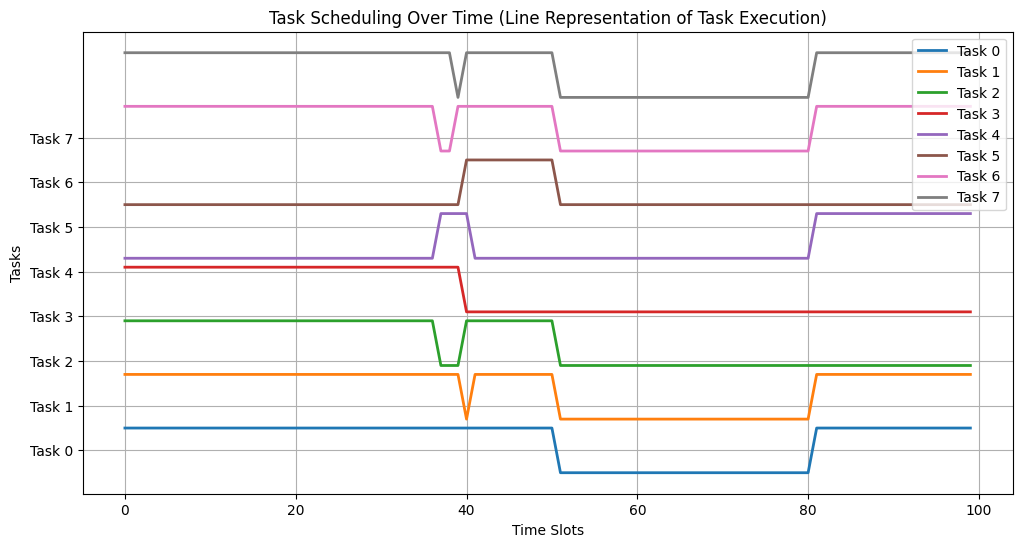

In [14]:
start_time = datetime(2025, 1, 1, 0, 0, 0)
Satellite_optimization(satellite_data_2U,satellites[1],start_time)

Instance 3 - 3U Cubesat


===== Optimization Results =====
Status: Optimal
Objective Value: 595.0
Computation Time: 1.1672 seconds

===== Scheduled Tasks =====
Task ID                                                                                                                                                                                                                                             Scheduled Time Slots
 Task 0                                                                                                                                                                                                                           0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 18
 Task 1                                                            6, 14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99
 Task 2 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

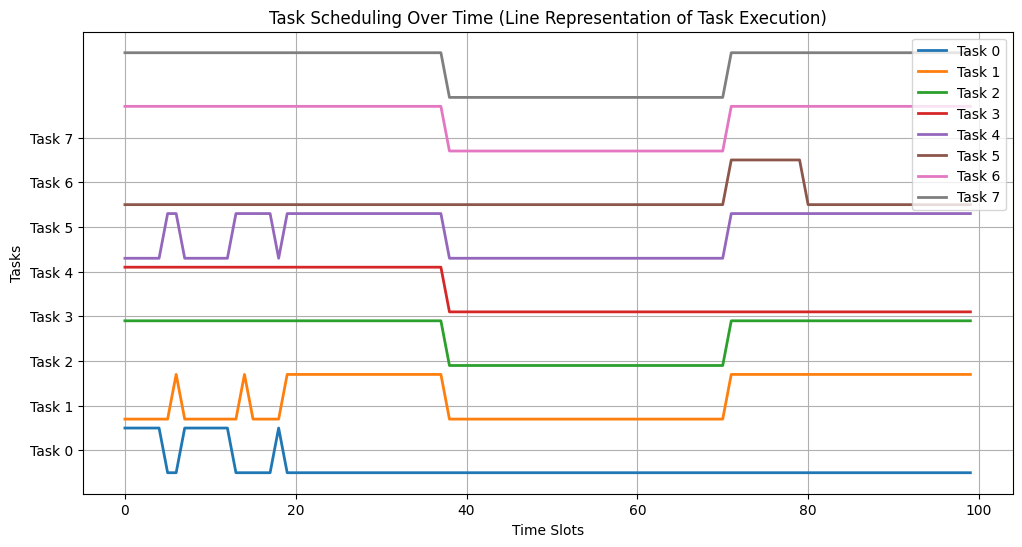

In [8]:
start_time = datetime(2025, 1, 1, 0, 0, 0)
Satellite_optimization(satellite_data_3U,satellites[2],start_time)